In [1]:
import pandas as pd
import numpy as np
from trails.read_data import get_obs_state_dct
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
from trails.optimizer import post_prob
%load_ext rpy2.ipython

n_sites = 200000
# name = 'sim_45ILS_0.5sel'
# name = 'sim_45ILS_nosel'
name = '../results/sim_45ILS_0.5sel_deep'

In [2]:
# import msprime
# 
# ploidy = 2
# pop_size = 10_000
# 
# ts = msprime.sim_ancestry(
#     samples=[msprime.SampleSet(4, ploidy=1)], 
#     sequence_length=10, random_seed=2, 
#     recombination_rate=0.00001/ploidy, 
#     population_size = pop_size*ploidy, 
#     ploidy = 1
# )
# ts.draw_svg(y_axis=True)

In [3]:
# ts = msprime.sim_ancestry(
#     samples=[msprime.SampleSet(4, ploidy=1)], 
#     sequence_length=10, random_seed=2, 
#     recombination_rate=0.00001/ploidy, 
#     population_size = pop_size, 
#     ploidy = ploidy
# )
# ts.draw_svg(y_axis=True)

In [4]:

def mutations(dir_name, i):
    """
    This function parses the SLiM output for a certain sample.
    """
    # Save the mutations
    with open(f'{dir_name}_{i}.log', 'r') as f:
        mut = False
        for line in f:
            if line == 'Mutations:\n':
                mutations = []
                mut = True
            elif line == 'Genomes:\n':
                break
            elif mut:
                mutations.append(line.strip('\n'))
    l = [m.split(' ')+[i] for m in mutations]
    return l

# def genome(i):
#     """
#     This function parses the SLiM output for a certain sample.
#     """
#     # Save the mutations
#     with open(f'simulation_{i}.log', 'r') as f:
#         mut = False
#         for line in f:
#             if line == 'Genomes:\n':
#                 mutations = []
#                 mut = True
#             elif mut:
#                 mutations.append(line.strip('\n'))
#     mutations = mutations[0].split('A ')[1]
#     return [int(i) for i in mutations.split(' ')]


In [5]:
def slim_to_df(dir_name):
    # Run the function for all samples
    l_tot = []
    for i in ['1', '2', '3', '4']:
        l = mutations(dir_name, i)
        l_tot = l_tot + l

    # Make pandas data frame
    df = pd.DataFrame(l_tot, 
                       columns = ['mut_id_sample', 'id', 'type', 'pos', 'sel', 'dom', 'pop', 'time', 'prev', 'sam'])
    # Drop temporary mutation id
    df = df.drop(['mut_id_sample'], axis=1)
    # Calculate max time per position and sample, in case there are multiple mutations on the same position
    df['max'] = df.groupby(['pos', 'sam'])['time'].transform(max)
    # Only keep latest mutation
    df = df[df['time'] == df['max']]
    # Merge samples
    df = df.groupby(['id', 'pos', 'time'])['sam'].apply(lambda x: ''.join(x)).reset_index()
    # Get genotype
    df['sam2'] = [''.join(['1' if str(y) in x else '0' for y in range(1, 5)]) for x in df['sam']]
    # Change type
    df = df.astype({"id":"int", "pos":"int"})
    # Arrange values by time
    df = df.sort_values('time')
    return df

In [6]:
# df_test = slim_to_df('simulation')
# df_test

In [7]:
def genotype(site, sam2): 
    """
    This function samples a random nt for a mutation
    """
    nochange_lst = ['A', 'C', 'T', 'G']
    nochange_lst.remove(site.upper())
    geno1 = np.random.choice(nochange_lst, 1)[0]
    g_mut = ''.join([site if j == '0' else geno1 for j in sam2])
    return g_mut

In [8]:
def df_to_dfsim(df2, n_sites, seed):

    # Simulate random genome
    np.random.seed(seed); sim_genome = np.random.choice(['a', 'c', 't', 'g'], n_sites)

    # Save ancestral allele
    df2['geno'] = [sim_genome[i] for i in df2['pos']]
    # Change genotype according to mutational pattern
    np.random.seed(seed+1); df2['geno2'] = [genotype(variant[1]['geno'], variant[1]['sam2']) for variant in df2.iterrows()]
    # Calculate how many mutations per site
    df2['size'] = [list(df2['pos']).count(i) for i in df2['pos']]
    df2 = df2.sort_values(['pos', 'time'])

    return df2, sim_genome

In [9]:
# df_test_2, sim_genome_test = df_to_dfsim(df_test, n_sites, 5)
# df_test_2[df_test_2['size'] > 1]

In [10]:

def combine_sam2(x):
    """
    This function combines sam2 columns
    """
    l = []
    acc = 1
    for i in x:
        i = i.replace('1', str(acc))
        l.append(i)
        acc += 1
    res = '0000'
    for i in l:
        for j in range(len(i)):
            if i[j] != '0':
                list1 = list(res)
                list1[j] = i[j]
                res = ''.join(list1)
    return res

def combine_geno2(x):
    """
    This function combines geno2 columns
    """
    acc = 1
    for i in x:
        for j in i:
            if j in ['a', 'c', 't', 'g']:
                low = j
    res = low+low+low+low
    for i in x:
        for j in range(len(i)):
            if i[j] != low:
                list1 = list(res)
                list1[j] = i[j]
                res = ''.join(list1)
    return res.upper()

In [11]:
def clean_dfsim(df2, sim_genome):
    df3 = df2.groupby(['pos']).agg(
        {'id': 'max', 
         'time': 'max',
         'sam': 'max',
         'sam2': combine_sam2,
         'geno': 'max',
         'geno2': combine_geno2,
         'size': 'max'
        }).reset_index()

    # Get dictionary from data frame
    d = dict(zip(df3.pos, df3.geno2))
    # Get ancestral genotype
    sim_genome_upper = [i.upper()*4 for i in sim_genome]
    # Add mutations at the right location
    for i in list(d.keys()):
        sim_genome_upper[i] = d[i]
    lst_index = get_obs_state_dct()
    sim_genome_idx = [lst_index.index(i) for i in sim_genome_upper]
    return sim_genome_idx


In [12]:
def wrapper(dir_name, n_sites, seed):
    df = slim_to_df(dir_name)
    df2, sim_genome = df_to_dfsim(df, n_sites, seed)
    return clean_dfsim(df2, sim_genome)

In [13]:
sim_genome_idx = np.array(wrapper(name, n_sites, 1))
sim_genome_idx

array([ 85, 255,   0, ...,   0,  84, 255])

In [14]:
import msprime, tskit
ts = tskit.load(name+".trees")
ts = ts.simplify()
ts = ts.simplify(samples = [0, 2, 4, 6])

t = ts.first()
t_new = t.as_newick(include_branch_lengths=False)
t_new

'(n3,(n2,(n0,n1)));'

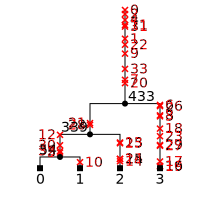

In [15]:
t.draw_svg()

In [16]:
# find_re = [sorted(re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0].split(',')) for t in ts.trees()]
# find_re_2 = [r != ['n0', 'n1'] for r in find_re]
# sum(find_re_2)/len(find_re_2)

In [17]:
ILS = 32

t_A = 200000
t_B = 200000
t_C = 200000
t_1 = max([t_A, t_B, t_C])
N_AB = 80000
t_2 = -N_AB*np.log(3/2*ILS/100)
N_ABC = 70000
t_3 = t_1*5
r = 0.5e-8
mu = 1.5e-8

n_int_AB = 5
n_int_ABC = 7

N_ref = N_ABC

t_out = t_1+t_2+t_3+2*N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)

cut_AB_down = cut_AB/200
cut_ABC_down = cut_ABC/200

(2/3)*(np.exp(-t_2/(N_AB)))

0.31999999999999995

In [18]:
cut_AB_down

array([1000.        , 1043.9259464 , 1093.27755487, 1149.58657642,
       1215.14171846, 1293.58767003])

In [19]:
cut_ABC_down-max(cut_AB_down)

array([  0.        ,  53.95273794, 117.76528282, 195.86552578,
       296.55425114, 438.46703897, 681.06855217,          inf])

In [20]:
# from trails.optimizer import forward_loglik
# from trails.optimizer import trans_emiss_calc
# 
# base = [1e-6, 0.25e-6]
# 
# for mult in [0.5, 1, 2]:
#     mu_2 = base[0]*mult
#     r_2 = base[1]*mult
#     print(mu_2, r_2)
#     a, b, pi, h, o = trans_emiss_calc(
#         t_A, t_B, t_C, t_2, t_upper, t_out,
#         N_AB, N_ABC,
#         r_2, mu_2, mu_2, mu_2, mu_2, mu_2, mu_2, n_int_AB, n_int_ABC)
#     print(forward_loglik(a, b, pi, sim_genome_idx))
# 
# # With selection
# # 5e-07 1.25e-07
# # -358428.0432866292
# # 1e-06 2.5e-07
# # -356066.85303972726
# # 2e-06 5e-07
# # -359863.7415640234
# # Without selection
# # 5e-07 1.25e-07
# # -358531.7510514303
# # 1e-06 2.5e-07
# # -356164.4614222776
# # 2e-06 5e-07
# # -359933.1014032446

In [ ]:
from trails.optimizer import trans_emiss_calc

if 'transitions' not in locals():
    transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
        t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
        N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC)

    dct_hid = {v: k for k, v in hidden_states.items()}
    dct = {v: k for k, v in observed_states.items()}

2023-05-01 18:17:12,906	INFO worker.py:1518 -- Started a local Ray instance.


In [ ]:
emissions

In [ ]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1/200+t_2/200):
            state = (1, (mint>=cut_ABC_down).sum()-1, (mint2>cut_ABC_down).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>=cut_AB_down).sum()-1, (mint2>cut_ABC_down).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>=cut_ABC_down).sum()-1, (mint2>cut_ABC_down).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>=cut_ABC_down).sum()-1, (mint2>cut_ABC_down).sum()-1)
    else:
        state = (4, (mint>cut_ABC_down).sum()-1, (mint2>cut_ABC_down).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

    


In [ ]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
# tree_state_corrected = [tuple(abs(i) for i in j) for j in tree_state]
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [ ]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [ ]:
from trails.optimizer import post_prob_wrapper

post = post_prob_wrapper(transitions, emissions, starting, [sim_genome_idx])

In [ ]:
post_1 = post[0]

In [ ]:
%%R -i post_1 -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
    
# write_csv(hid_tab, 'hid_tab.csv')
    
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
# write_csv(tree_tab, 'tree_tab.csv')

post_tab <- as_tibble(post_1) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')
     
# write_csv(post_tab, 'post_tab.csv')

In [ ]:
%%R

# library(tidyverse)
# 
# hid_tab <- read_csv('hid_tab.csv')
# tree_tab <- read_csv('tree_tab.csv')
# post_tab <- read_csv('post_tab.csv')

In [ ]:
%%R -i n_sites

tree_tab %>%
    group_by(topology) %>%
    summarize(
        n = sum(end-start)/n_sites
    )

In [ ]:
%%R -w 2000 -h 700 -r 150 -i n_int_AB

p1 <- post_tab %>%
    mutate(is_V0 = topology == 0) %>%
    group_by(pos, is_V0, int_1) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_1+(!is_V0)*(n_int_AB+0.1), fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_1+(!(topology == 0))*(n_int_AB+0.1), yend = int_1+(!(topology == 0))*(n_int_AB+0.1)), 
                 color = 'red',
                 data = tree_tab) +
    scale_fill_viridis_c(limits=c(0,1)) +
    scale_color_viridis_c(limits=c(0,1)) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    labs(y = 'First coalescent', x = 'Position')
    
p1

In [ ]:
%%R -w 2000 -h 700 -r 150

p2 <- post_tab %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_2, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2), 
                 color = 'red',
                 data = tree_tab) +
    scale_fill_viridis_c(limits=c(0,1)) +
    scale_color_viridis_c(limits=c(0,1)) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    labs(y = 'Second coalescent') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank()
    )

p2

In [ ]:
%%R -w 900 -h 500 -r 150

library(PhaseTypeR)

deep = 0.45+0.45/2

mat_double = matrix(c(-3, 0, 3, -1), nrow = 2)
mat_single = matrix(c(-1), nrow = 1)
ph_double = PH(mat_double)
ph_single = PH(mat_single)
# ph_single_3 = PH(mat_single*3)
# x = seq(0, 3, length.out = 1000)
# y_double = dPH(x, ph_double)
# y_single = dPH(x, ph_single)
# y_single_3 = dPH(x, ph_single_3)

quant = (1:6)/7
# quant_double = qPH(quant, ph_double)
quant_single = qPH(quant, ph_single)

p_double = pPH(quant_single, ph_double)
theoretical_prop_deep <- c(p_double, 1)-c(0, p_double)
p_single = pPH(quant_single, ph_single)
theoretical_prop_shallow <- c(p_single, 1)-c(0, p_single)

# ggplot() +
#     geom_line(aes(x, y_double, color = 'PH')) +
#     geom_line(aes(x, y_single_3, color = 'exp(3)')) +
#     geom_line(aes(x, y_single, color = 'exp(1)')) +
#     geom_vline(aes(xintercept = quant_single, color = 'exp(1)'), linetype = 2) +
#     theme_minimal()

theoretical_prop = (theoretical_prop_deep*deep+theoretical_prop_shallow*(1-deep))

theoretical_prop

In [ ]:
%%R -i n_int_ABC

# int_2_tab_post <- post_tab %>%
#     group_by(pos, int_2) %>%
#     summarize(prob = sum(value)) %>%
#     group_by(int_2) %>%
#     summarize(
#         suma = sum(prob)/n_sites
#     ) %>%
#     ungroup() %>%
#     arrange(desc(int_2)) %>%
#     mutate(Type = 'Posterior mean')
    
int_2_tab_post2 <- post_tab %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    group_by(pos) %>%
    filter(prob == max(prob)) %>%
    group_by(int_2) %>%
    summarize(
        suma = n()/n_sites
    ) %>%
    ungroup() %>%
    arrange(desc(int_2)) %>%
    mutate(Type = 'Posterior max')
    
int_2_tab_true <- tree_tab %>% 
    group_by(int_2) %>%
    summarize(
        suma = sum(end-start)/n_sites
    ) %>%
    ungroup() %>%
    arrange(desc(int_2)) %>%
    mutate(Type = 'Empirical')

int_2_tab_theo <- tibble(
    int_2 = 0:(n_int_ABC-1),
    suma = theoretical_prop,
    Type = 'Theoretical'
)
    

In [ ]:
%%R -w 900 -h 500 -r 150  -i name

library(ggthemes)

plot_post_binned <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true, 
    int_2_tab_post2, 
    int_2_tab_theo
    ) %>%
    mutate(Type = factor(Type, (c('Theoretical', 'Empirical', 'Posterior mean', 'Posterior max')))) %>% 
    ggplot() +
    geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    theme_few() +
    labs(x = 'Second coalescent bin', y = 'Proportion') +
    scale_x_continuous(breaks = 0:(n_int_ABC-1)) +
    scale_y_continuous(limits = c(0, 0.62), expand = c(0, 0)) +
    scale_fill_manual(values = c('#2596be', '#b01e81', '#81b01e'), 
                      breaks = rev(c('Theoretical', 'Empirical', 'Posterior max'))) +
    theme(
        axis.title.y = element_blank(),
        legend.position = c(0.83, 0.7)
    ) +
    coord_flip()
    
plot_post_binned

In [ ]:
%%R -w 900 -h 500 -r 150  -i name

ggsave(paste0('second_coalescent_proportion_', name, '.png'), plot_post_binned, width = 10/2, height = 5/2)

In [ ]:
%%R -w 2000 -h 700 -r 150

p3 <- post_tab %>%
    group_by(pos, topology) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, topology, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = topology, yend = topology), 
                 color = 'red',
                 data = tree_tab) +
    scale_fill_viridis_c(limits=c(0,1)) +
    scale_color_viridis_c(limits=c(0,1)) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    labs(y = 'Topology') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank()
    )

p3

In [ ]:
%%R -w 2000 -h 1000 -r 150 -i name

library(patchwork)

ggsave(paste0('posterior_decoding_', name, '.png'), plot = p3/p2/p1, width = 14, height = 7)

In [ ]:
# from trails.optimizer import optimizer
# 
# dct = {'t_1':[16000, 1600, 160000], 't_2':[4000, 400, 40000], 't_upper':[20000, 2000, 200000], 
#        'N_AB':[1000, 100, 10000], 'N_ABC':[5000, 500, 50000], 'r':[1e-8, 1e-9, 1e-7]}
# dct2 = {'n_int_AB':3, 'n_int_ABC':3, 'mu':2e-8}
# res_name = 'name.csv'
# optimizer(dct, dct2, sim_genome_idx, res_name)